# Spatial Representation Efficiency and Accuracy in ConvNets
It has been claimed that naive implementations of convolutional networks are inappropriate for computing spatial transformations - particularly where the network is expected to compute the spatial position of a feature within an image (Liu et al, 2016). Liu et al proposed a new architectural component, the CoordConv layer, with the goal of explicitly supporting the capture and encoding of spatial information.

I appear to have run into such problems in my own experiments on a larger problem of image alignment, however I have also found that simple convolutional networks can indeed encode spatial information without explicit architecture. This conclusion is further supported by the wide range of networks that directly compute spatial information such as image alignment (DeTone et al, 2016), and bounding boxes (Redmond et al, 2016) without explicit architectural components such as CoordConv.

I suspect that different architectures vary not in a strict binary sense of whether or not they can encode and transform spatial information, but rather in how efficient they are in computing and encoding that spatial information, and consequently in how accurate their final outputs are for a given computational capacity. This notebook examines a few architectures and tries to directly measure and contraist their informational encoding efficiency.

The notebook is broken into a few sections:
* Helper code - various functions, custom layers, and plotting tooling that we'll use throughout.
* Architectures - each architecture is described, a theory proposed, and then results measured.
* Summary - results from each architecture are compared.

### See Also
Initial results and experiments were carried out within the following notebooks:
* https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3a_SpatialAccuracy.ipynb
* https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3b_SpatialLayerTesting.ipynb
* https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3c_Hypertuning.ipynb


### References
* DeTone, D., Malisiewicz, T., Rabinovich, A (2016). Deep image homography estimation. ArXiv. https://arxiv.org/abs/1606.03798

* Liu, R., Lehman, J., Molino, P., et al (2016). An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution. NeurIPS 2018.
https://arxiv.org/abs/1807.03247v2

* Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). You Only Look Once: Unified, Real-Time Object Detection. ArXiv. https://arxiv.org/abs/1506.02640



In [1]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout 550ac65
sys.path.append('training-instrumentation-toolkit')

# Load standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import tensorflow as tf
from tensorflow.keras import layers
import IPython.display as idisplay
import time
import os
import sys
import math
import tqdm
import cv2
import re

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1645, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 1645 (delta 135), reused 109 (delta 57), pack-reused 1440 (from 2)
Receiving objects: 100% (1645/1645), 247.86 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (992/992), done.
Note: switching to '550ac65'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 550ac65 Referencing blog post
TensorFlow version: 2.18.0


## Dataset
The dataset is a set of black images with the top-left corner of a thick-edged frame appearing somewhere within the main area of the image (avoiding the area near the edge for simplicity). The images have a low-density white-spot noise. The task of the model is to identify the location of the frame corner.

### Image Format
For completely arbitrary reasons, I'm using images of size `149x149x1` (grayscale), and coordinates are represented as a fraction of image width, relative to the image centre. ie: x, y both in range `-0.5 .. +0.5`.

Image centre is always exactly at `149 // 2 = 74`.

Where it matters, the integer coordinate of a pixel is considered to identify the centre of the pixel.

### Model Outputs
As we'll be working with models of different architectures, we'll also be working with two different output formats:

1. The `(x,y)` coordinate of frame corner (in range `-0.5 .. +0.5`)
2. A heatmap of size `149x149x1` where the 3x3 grid surrounding the max value are used to represent the coordinate of the frame corner.

In the latter case, the values of the peak 3x3 grid are used as a weighted sum of the coordinates of the pixels in that grid, producing a single `(x,y)` coordinate with sub-pixel precision.

### Dataset Format
In order to support the different model architectures, the core dataset is made up of tuples: `(input_image, true-xy-coord, true-heatmap)`.

image shape: (149, 149, 1), val range: 0.0 .. 1.0


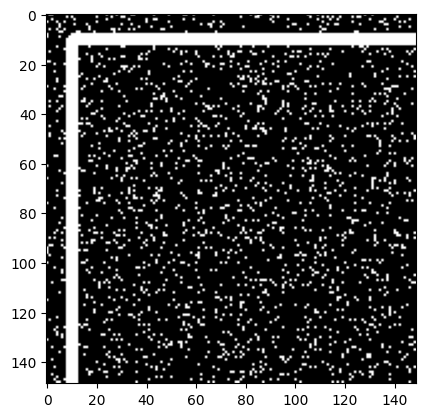

In [2]:
def generate_training_image(x, y, width=149, height=149):
  """
  Generates the input image for training and validation.
  Note: only works for integer (x,y) because OpenCV.line() doesn't support sub-pixel resolution.
  """
  img = np.zeros((height, width), dtype=np.uint8)

  # Add speckled noise
  noise_density = 0.1  # Adjust for more/less speckles
  num_noise_pixels = int(noise_density * img.size)
  xs = np.random.randint(0, width, num_noise_pixels)
  ys = np.random.randint(0, height, num_noise_pixels)
  img[ys, xs] = 255

  # Draw vertical line (down from (x, y))
  cv2.line(img, (x, y), (x, height-1), 255, thickness=3)

  # Draw horizontal line (right from (x, y))
  cv2.line(img, (x, y), (width-1, y), 255, thickness=3)

  # Rescale value to 0.0 .. 1.0
  # Add channel dimension for grayscale
  return img[..., np.newaxis] / 255.0

im = generate_training_image(10,10)
print(f"image shape: {np.shape(im)}, val range: {np.min(im)} .. {np.max(im)}")
plt.imshow(im, cmap='gray')
plt.show()

image shape: (149, 149, 1), val range: 0.0 .. 0.25


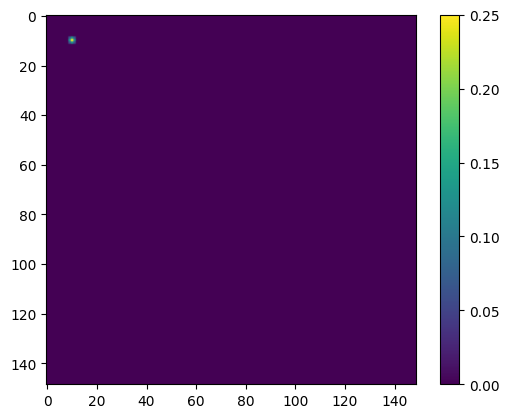

In [3]:
def generate_soft_3x3(x_fp, y_fp, coordinate_radius=1.0):
    """
    Used to construct the ground-truth heatmap for a given coordinate.
    This function computes just the 3x3 grid surrounding the given coordinate,
    with values such that its weighted sum of coordinates resolves as the requested
    coordinate (with sub-pixel precision and accuracy).

    Generate a normalized 3x3 kernel centered around (x_fp, y_fp), relative to pixel centers.
    The output weights sum to 1.

    Computes weights as the percentage coverage by a partially enlarged square pixel placed
    exactly onto the floating-point-precision coordinate.
    Experiments found that this approach produces the most accurate results compared to some approaches.
    See https://github.com/malcolmlett/robovac/blob/main/experiments-slam/Experiment_ADLO_3a_SpatialAccuracy.ipynb for other experiments.

    Note: assumes that pixel integer coordinates are located at the pixel centres.
    This is consistent with OpenCV and matplotlib.

    Args:
      coordinate_radius - must be in range 0.0..1.0, where 0.5 = normal pixel size.
        Works best with 1.0.
    """
    def row_coverage(fp):
      row = np.array([-1, 0, +1])
      overlap_left = np.maximum(row - 0.5, fp - coordinate_radius)
      overlap_right = np.minimum(row + 0.5, fp + coordinate_radius)
      overlap = np.clip(overlap_right - overlap_left, 0.0, 1.0)
      return overlap

    # Convert (x_fp, y_fp) to grid coordinate system
    # - assumes grid is placed such that (x_fp,y_fp) is within bounds of central pixel (ie: in range -0.5..+0.5)
    x_fp = x_fp - round(x_fp)
    y_fp = y_fp - round(y_fp)

    # Compute weights
    # - doing x and y axis separately, and then combining into a grid
    dx = row_coverage(x_fp)
    dy = row_coverage(y_fp)
    weights = np.matmul(dy[:, np.newaxis], dx[np.newaxis, :])

    # Normalize weights and return
    weights /= np.sum(weights)
    return weights  # shape (3, 3)

def generate_heatmap_image(x, y, width=149, height=149):
  """
  Generates a heatmap that is mostly zeros, with a 3x3 spot at the target
  coordinate that identifies its exact location to sub-pixel resolution.
  The weighted sum of the coordinates of the non-zero positions,
  weighted by the heatmap magnitudes, will result in exactly the original coordinate.
  """
  img = np.zeros((height, width), dtype=np.float32)
  weights = generate_soft_3x3(x, y)

  xc = int(np.round(x))
  yc = int(np.round(y))

  for dy in range(-1, 2):
    for dx in range(-1, 2):
      xi = xc + dx
      yi = yc + dy
      if 0 <= xi < width and 0 <= yi < height:
        img[yi, xi] = weights[dy + 1, dx + 1]

  return img[..., np.newaxis]

im = generate_heatmap_image(10,10)
print(f"image shape: {np.shape(im)}, val range: {np.min(im)} .. {np.max(im)}")
plt.imshow(im)
plt.colorbar()
plt.show()

In [4]:
def weighted_peak_coordinates(pred, system='unit-scale'):
    """
    Computes the (x,y) coordinates of the peak in a heatmap, taken as the value-weighted
    sum of coordinates in a 3x3 grid surrounding the max value.

    Basically, reverses generate_heatmap_image().

    Args:
      pred - predicted heatmaps of shape (B, H, W, C)
      system - 'unit-scale' or 'pixels'.
        The models are dataset assume a 'unit-scale' where the coordinates are given
        as a fraction of the image width/height, relative to the image centre
        and each have the range -0.5 .. +0.5.

        The alternative is the original pixel coordinates, with floating-point precision.
    Returns:
      (B, C, 2) tensor of predicted subpixel (x, y) coordinates
    """
    #B, H, W, C = pred.shape[0], pred.shape[1], pred.shape[2], pred.shape[3]
    B, H, W, C = tf.unstack(tf.shape(pred))

    # Prepare input
    # - map to (B, C, H, W) because we're iterating along B & C dimensions,
    #   while selecting into H & W dimensions
    # - pad +/- 1 along H and W dimensions to allow safe 3x3 extraction
    pred = tf.transpose(pred, [0, 3, 1, 2])
    pred = tf.pad(pred, [[0, 0], [0, 0], [1, 1], [1, 1]])

    # Find (x,y) argmax for each channel
    x_peaks = tf.reduce_max(pred, axis=2)                        # (B, W+2, C)
    x_peaks = tf.argmax(x_peaks, axis=-1, output_type=tf.int32)  # (B, C)
    y_peaks = tf.reduce_max(pred, axis=3)                        # (B, H+2, C)
    y_peaks = tf.argmax(y_peaks, axis=-1, output_type=tf.int32)  # (B, C)
    x_peaks = tf.reshape(x_peaks, [B, C, 1])                     # (B, C, 1)
    y_peaks = tf.reshape(y_peaks, [B, C, 1])                     # (B, C, 1)

    # Offsets for 3x3 patch
    dx = tf.constant([-1, 0, 1], tf.int32)
    dy = tf.constant([-1, 0, 1], tf.int32)
    dx, dy = tf.meshgrid(dx, dy)
    dx = tf.reshape(dx, [1, 1, -1])  # (1, 1, 9)
    dy = tf.reshape(dy, [1, 1, -1])  # (1, 1, 9)

    # Compute (x, y) indices for 3x3 patches centered at (x_peaks, y_peaks)
    grid_x_indices = x_peaks + dx  # broadcast to (B, C, 9)
    grid_y_indices = y_peaks + dy  # broadcast to (B, C, 9)
    grid_indices = tf.stack([grid_y_indices, grid_x_indices], axis=-1)  # (B, C, 9, 2)

    # Compute (x, y) coordinates for 3x3 patches centered at (x_peaks, y_peaks)
    # - remove padding
    value_type = pred.dtype
    grid_x_coords = tf.cast(grid_x_indices - 1, value_type)  # (B, C, 9)
    grid_y_coords = tf.cast(grid_y_indices - 1, value_type)  # (B, C, 9)

    # Collect indexed values and normalize as weights
    patch_vals = tf.gather_nd(pred, grid_indices, batch_dims=2)  # (B, C, 9)
    weights = patch_vals / tf.reduce_sum(patch_vals, axis=-1, keepdims=True)

    # Computed value-weighted sum of coordinates
    x_coords = tf.reduce_sum(weights * grid_x_coords, axis=-1)  # (B, C)
    y_coords = tf.reduce_sum(weights * grid_y_coords, axis=-1)  # (B, C)
    coords = tf.stack([x_coords, y_coords], axis=-1)            # (B, C, 2)

    if system == "unit-scale":
      size = tf.cast(tf.reshape(tf.stack([W, H]), [1, 1, 2]), coords.dtype)
      # must be exactly this in order to exactly reverse the 'unit-scale to pixel' conversions used elsewhere
      return (coords - (size // 2)) / size
    elif system == "pixels":
      return coords
    else:
      raise ValueError(f"Invalid coordinate system: {system}")

# batch size = 3, channels = 1 -> pixels
images = tf.stack([generate_heatmap_image(10,10), generate_heatmap_image(10.51,13.2), generate_heatmap_image(29.74,17.432)], axis=0)
coords = weighted_peak_coordinates(images, system='pixels')
print(f"images {images.shape} -> coords #1 {coords.shape}: {coords}")
tf.debugging.assert_near(coords, [[[10.0, 10.0]], [[10.51, 13.2]], [[29.74, 17.432]]])

# batch size = 1, channels = 3 -> pixels
images = tf.stack([generate_heatmap_image(10,10), generate_heatmap_image(10.51,13.2), generate_heatmap_image(29.74,17.432)], axis=-1)
images = tf.reshape(images, [1, 149, 149, -1])
coords = weighted_peak_coordinates(images, system='pixels')
tf.debugging.assert_near(coords, [[[10.0, 10.0], [10.51, 13.2], [29.74, 17.432]]])
print(f"images {images.shape} -> coords #2 {coords.shape}: {coords}")

# batch size = 3, channels = 1 -> unit-scale
images = tf.stack([generate_heatmap_image(10,10), generate_heatmap_image(10.51,13.2), generate_heatmap_image(29.74,17.432)], axis=0)
coords = weighted_peak_coordinates(images, system='unit-scale')
print(f"images {images.shape} -> coords #3 {coords.shape}: {coords}")

images (3, 149, 149, 1) -> coords #1 (3, 1, 2): [[[10.       10.      ]]

 [[10.51     13.2     ]]

 [[29.740002 17.432   ]]]
images (1, 149, 149, 3) -> coords #2 (1, 3, 2): [[[10.       10.      ]
  [10.51     13.2     ]
  [29.740002 17.432   ]]]
images (3, 149, 149, 1) -> coords #3 (3, 1, 2): [[[-0.4295302  -0.4295302 ]]

 [[-0.42610738 -0.4080537 ]]

 [[-0.29704696 -0.379651  ]]]


In [5]:
def create_dataset(n=1000, width=149, height=149):
  """
  Creates full dataset as tuples of (input_image, coordinate_output, heatmap_output)
  """
  # generate random coordinates
  # - units: fraction of width/height, relative to centre, in range -0.5 .. +0.5
  # - avoid 10%-width edge -> so limit to range -0.4 .. +0.4
  # - discretize to align to pixels by converting to pixel coords and then back again
  sizes = tf.constant([[height, width]], dtype=tf.float32)
  corner_coords = tf.random.uniform(shape = (n,2), minval = -0.4, maxval = +0.4)  # float in range -0.4 .. +0.4
  corner_coords = tf.cast(tf.round(corner_coords * sizes + sizes//2), tf.int32)   # int in range 14 .. 134
  corner_coords = (tf.cast(corner_coords, tf.float32) - sizes//2) / sizes         # float in approx. range -0.4 .. +0.4, but discretized

  images = []
  heatmaps = []
  for corner_coord in tqdm.tqdm(corner_coords):
    abs_coord = np.array(corner_coord * 149 + 149//2, dtype=np.int32)
    image = generate_training_image(abs_coord[0], abs_coord[1])
    heatmap = generate_heatmap_image(abs_coord[0], abs_coord[1])
    images.append(tf.constant(image, tf.float32))
    heatmaps.append(tf.constant(heatmap, tf.float32))
  dataset = tf.data.Dataset.from_tensor_slices((images, corner_coords, heatmaps))
  return dataset

def to_input_dataset(image, coord, heatmap):
  """
  Maps a dataset row to a single input_image.
  Usage: dataset.map(to_coordinate_dataset)
  """
  return image

def to_coordinate_dataset(image, coord, heatmap):
  """
  Maps a dataset row to a tuple of (input_image, coordinate_output).
  Usage: dataset.map(to_coordinate_dataset)
  """
  return (image, coord)

def to_heatmap_dataset(image, coord, heatmap):
  """
  Maps a dataset row to a tuple of (input_image, heatmap_output).
  Usage: dataset.map(to_heatmap_dataset)
  """
  return (image, heatmap)

In [6]:
def _plot_dataset_entry(image, corner_coords):
  abs_coords = corner_coords * 149 + 149//2
  plt.imshow(image, cmap='gray')
  plt.scatter(abs_coords[0], abs_coords[1], s=100, edgecolors='b', facecolors='none', linewidth=2)
  plt.axis('off')

def _plotadd_pred_coord(pred_coords):
  edge_x = -0.5 if pred_coords[0] < -0.5 else +0.5 if pred_coords[0] > 0.5 else None
  edge_y = -0.5 if pred_coords[1] < -0.5 else +0.5 if pred_coords[1] > 0.5 else None

  if edge_x is not None or edge_y is not None:
    if edge_x is not None:
      edge_x = edge_x * 149 + 149//2
      plt.plot([edge_x, edge_x], [0, 148], color='r', linewidth=2)
    if edge_y is not None:
      edge_y = edge_y * 149 + 149//2
      plt.plot([0, 148], [edge_y, edge_y], color='r', linewidth=2)
  else:
    abs_coords = pred_coords * 149 + 149//2
    plt.scatter(abs_coords[0], abs_coords[1], s=80, edgecolors='r', facecolors='none', linewidth=2)
  plt.plot(0, 0, 149, 149, color='r', linewidth=2)

def plot_dataset(dataset, model=None, n=10, show_heatmap=False):
  """
  Plot dataset with/without model predictions, and with/without heatmaps.
  If model is omitted, then any shown heatmap and prediction marker (red) are indicative
  of the ground-truth heatmap. Otherwise they are derived from the model output.

  Blue circles show ground-truth coordinates.
  Red circles show predicted coordinates.
  Perfect alignment can be seen by the (slightly smaller) red circles sitting
  perfectly ringed by the blue circle.

  Args:
   - dataset: original full dataset
  """
  if show_heatmap:
    cols = min(6,n)
    rows = math.ceil((n*2)/cols)
    plt.figure(figsize=(12,rows*2), layout='constrained')
  else:
    cols = min(5,n)
    rows = math.ceil(n/cols)
    plt.figure(figsize=(10,rows*2.5), layout='constrained')
  taken = dataset.take(n)

  if model is not None:
    predicted = model.predict(taken.map(to_input_dataset).batch(n))
    if predicted.shape[1:] != (2,):
      predicted_coords = weighted_peak_coordinates(predicted)
      predicted_coords = predicted_coords[:, 0, :]  # remove superfluous C dimension
    else:
      predicted_coords = predicted

    j = 0
    for i, (image, corner_coords, heatmap) in enumerate(taken):
      j += 1
      #if output.shape == (2,):
      #  corner_coords = output
      #else:
      #  corner_coords = weighted_peak_coordinates(tf.expand_dims(output, axis=0))
      #  corner_coords = corner_coords[0, 0, :]
      pred_coords = predicted_coords[i, ...]

      plt.subplot(rows, cols, j)
      _plot_dataset_entry(image, corner_coords)
      _plotadd_pred_coord(pred_coords)

      has_heatmap = (predicted[i, ...].shape != (2,))
      if has_heatmap and show_heatmap:
        j += 1
        plt.subplot(rows, cols, j)
        plt.imshow(predicted[i], cmap='gray')
        plt.axis('off')

  else:
    j = 0
    for i, (image, corner_coords, heatmap) in enumerate(taken):
      j += 1
      plt.subplot(rows, cols, j)
      plt.title(f"({corner_coords[0]:.3f},{corner_coords[1]:.3f})")
      _plot_dataset_entry(image, corner_coords)

      if show_heatmap:
        j += 1
        pred_coords = weighted_peak_coordinates(tf.expand_dims(heatmap, axis=0))
        pred_coords = pred_coords[0, 0, :]

        plt.subplot(rows, cols, j)
        plt.title("GT heatmap")
        _plot_dataset_entry(heatmap, corner_coords)
        _plotadd_pred_coord(pred_coords)
  plt.show()

Finally, create a one-off dataset and show how good the heatmap can be used to accurately calculate the ground-truth coordinates.

100%|██████████| 100/100 [00:00<00:00, 588.37it/s]


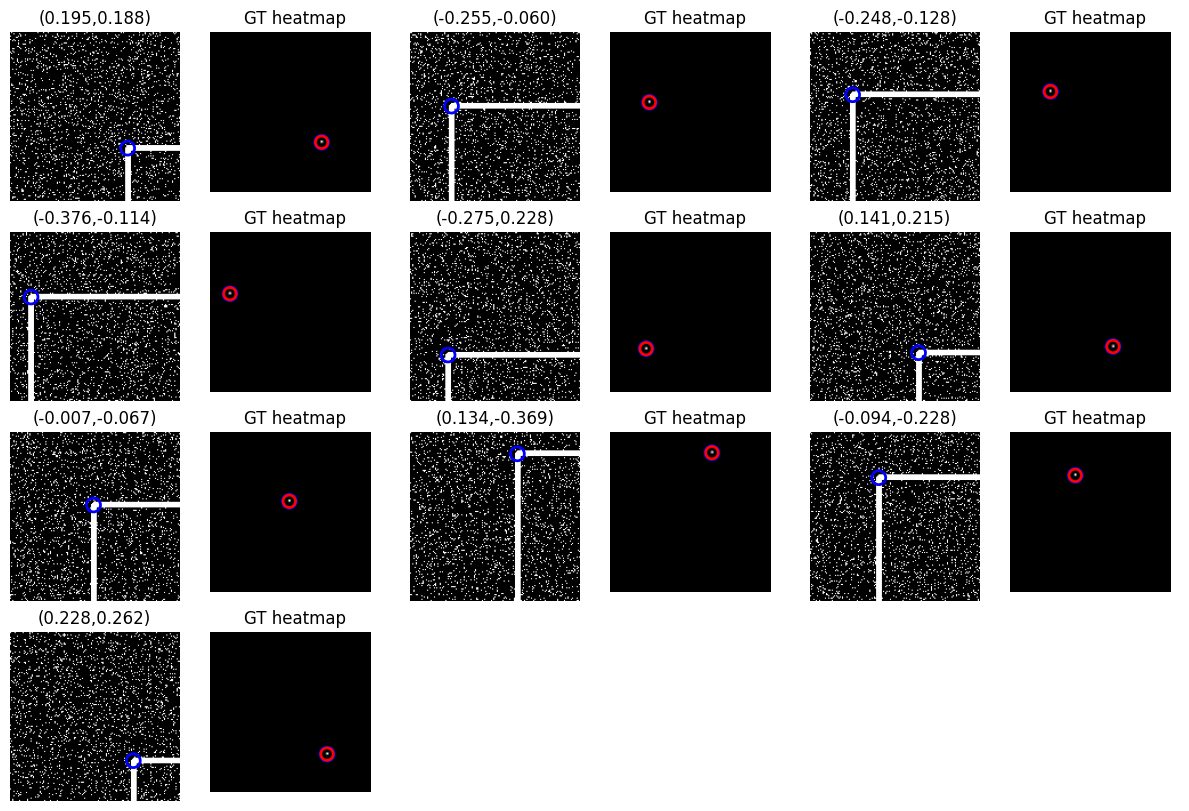

In [7]:
# create training and validation data
train_data = create_dataset(1000)
val_data = create_dataset(100)

# Plot some of the training dataset
#plot_dataset(train_data)
plot_dataset(train_data, show_heatmap=True)

## Custom Layers

We're going to use a number of custom layers in the models. So in the below we create those custom layers and run some sanity tests.

In [8]:
class HeatmapPeakCoord(layers.Layer):
  """
  Converts from (batch_size, height, width, channels) to (batch_size, channels, 2),
  giving the coordinates of the peak in each channel.
  The peak coordinates are weighted by the values in a 3x3 grid surrounding
  the single max value, for each channel.

  This layer just wraps the weighted_peak_coordinates() function.
  """
  def __init__(self, **kwargs):
      super().__init__(**kwargs)

  def call(self, inputs):
      return weighted_peak_coordinates(inputs, system='unit-scale')

# test using symbolic tensors
input = tf.keras.Input(shape=(149, 149, 3))
out = HeatmapPeakCoord()(input)
print(f"symbolic output: {type(out)}, shape: {out.shape}")

# test using real tensors
input = tf.stack([generate_heatmap_image(10,10), generate_heatmap_image(10.51,13.2), generate_heatmap_image(29.74,17.432)], axis=0)
out = HeatmapPeakCoord()(input)
print(f"actual output: {type(out)}, shape: {out.shape}")

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 3, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (3, 1, 2)


symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)


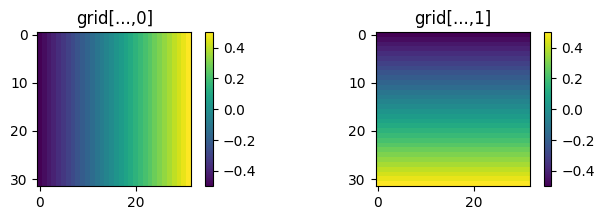

In [9]:
# Based on R. Liu et al., “An Intriguing Failing of CNNs and the CoordConv Solution,” NeurIPS 2018
# https://arxiv.org/abs/1807.03247
class CoordGrid2D(layers.Layer):
    """
    Returns a (batch_size, height, width, 2) tensor with a grid of (x,y) coordinates.
    Generally this will be subsequently concatenated with the input tensor.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid:
        # - x_coords: shape (width,) from -0.5 to 0.5
        # - y_coords: shape (height,) from -0.5 to 0.5
        x_coords = tf.linspace(-0.5, 0.5, width)
        y_coords = tf.linspace(-0.5, 0.5, height)

        # Use meshgrid to get 2D coordinate maps
        # - xx, yy shape => (height, width)
        xx, yy = tf.meshgrid(x_coords, y_coords)

        # Reshape for appending as channels
        xx = tf.expand_dims(xx, axis=-1)  # (height, width, 1)
        yy = tf.expand_dims(yy, axis=-1)  # (height, width, 1)

        # Tile across batch dimension
        xx_tiled = tf.tile(tf.expand_dims(xx, 0), [batch_size, 1, 1, 1])
        yy_tiled = tf.tile(tf.expand_dims(yy, 0), [batch_size, 1, 1, 1])

        # Output as grid with 2-channels
        # output.shape => [batch_size, height, width, 2]
        output = tf.concat([xx_tiled, yy_tiled], axis=-1)
        return output

# demo with symbolic tensor
input = tf.keras.Input(shape=(32, 32, 3))
cg = CoordGrid2D()(input)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# demo with concrete tensor
input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
print(f"actual output: {type(cg)}, shape: {cg.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()
plt.show()

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 33, 32, 2)


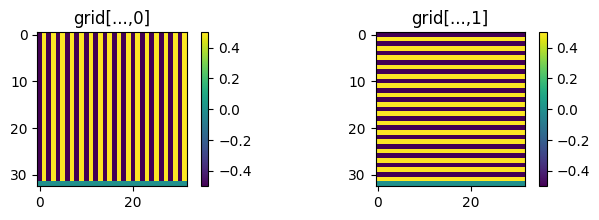

In [10]:
class StrideGrid2D(layers.Layer):
    """
    Inspired by the CoordGrid2D, but designed to be more convenient for strided spatial pooling.
    The computed positions are relative to the stride window, rather than the global image.

    Returns a (batch_size, height, width, 2) tensor with a grid of (x,y) coordinates.
    Coordinates are aligned to the strides of an assumed subsequent pooling layer,
    and indicate the relative position of the cell in the pool, relative to the
    pool's centre.
    For example, with stride=2, each 2x2 sub-grid has coordinates:
       [[-0.5,-0.5], [+0.5,-0.5]],
        [-0.5,+0.5], [+0.5,+0.5]].

    Generally this will be subsequently concatenated with the input tensor
    before applying a position-wise pooling operation.
    """
    def __init__(self, strides=2, **kwargs):
        super().__init__(**kwargs)
        self.strides = (strides, strides) if np.isscalar(strides) else strides

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid patch:
        # - x_coords: shape (stride_width,) from -0.5 to 0.5
        # - y_coords: shape (stride_height,) from -0.5 to 0.5
        # - xx, yy shape => (stride_height, stride_width)
        # - concatted: (stride_height, stride_width, 2)
        stride_height, stride_width = self.strides
        x_coords = tf.linspace(-0.5, 0.5, stride_width)
        y_coords = tf.linspace(-0.5, 0.5, stride_height)
        xx, yy = tf.meshgrid(x_coords, y_coords)
        grid = tf.concat([tf.expand_dims(xx, axis=-1), tf.expand_dims(yy, axis=-1)], axis=-1)

        # Tile across all patches in image
        # - Tile, then pad if needed
        # - (width, height, 2)
        patch_count_x = width // stride_width
        patch_count_y = height // stride_height
        x_pad = tf.cast(width - patch_count_x * stride_width, tf.int32)
        y_pad = tf.cast(height - patch_count_y * stride_height, tf.int32)
        tiled = tf.tile(grid, [patch_count_x, patch_count_y, 1])
        paddings = tf.stack([
            tf.stack([0, y_pad]),
            tf.stack([0, x_pad]),
            tf.stack([0, 0])
        ])
        tiled = tf.pad(tiled, paddings, 'CONSTANT')

        # Tile across batch dimension
        output = tf.tile(tf.expand_dims(tiled, 0), [batch_size, 1, 1, 1])
        return output

# demo with symbolic tensor
input = tf.keras.Input(shape=(32, 32, 3))
cg = StrideGrid2D()(input)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# demo with concrete tensor
input = tf.zeros((1, 33, 32, 3))
cg = StrideGrid2D(strides=2)(input)
print(f"actual output: {type(cg)}, shape: {cg.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("grid[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("grid[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()
plt.show()

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


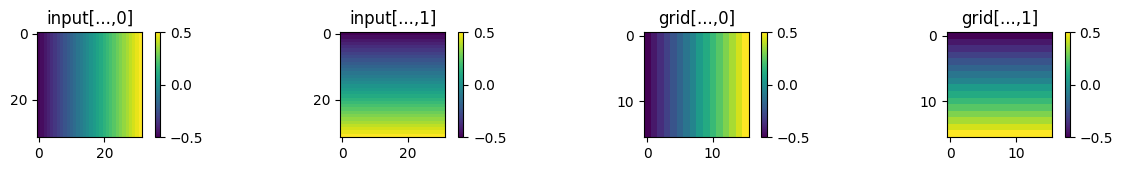

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


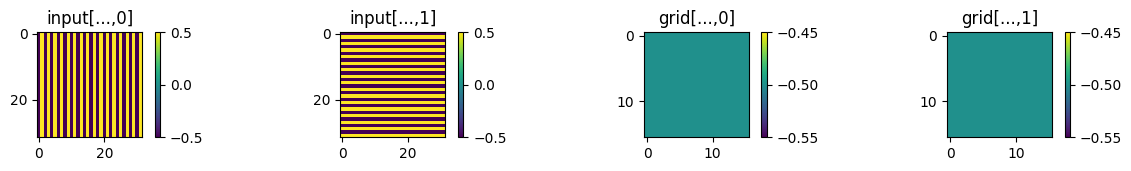

In [11]:
class PositionwiseMaxPool2D(tf.keras.layers.Layer):
    """
    Inspired by max-pool, however, where max-pool treats each channel separately,
    this groups all features together for a given 2D position. This in theory allows for more
    direct transport of spatial information from a CoordGrid2D or StrideGrid2D input.

    Pooling operation that selects all channels from the same position as a single unit.
    Positions are chosen by arg-max over a reduction operation (sum-of-squares).

    Use channel_weights to exclude some channels from the reduction.
    For example, if the first 32 channels are from semantic features, while the last 2 channels
    come from a CoordGrid2D input, then given the first 32 channels a weight of 1.0 each, and the last 2 channels a weight of 0.0.
    This way only the semantic features are arg-maxed over. Otherwise the arg-max operation
    will be biased towards the position with a larger coordinate value.
    """

    def __init__(self, pool_size=(2, 2), strides=None, channel_weights=None, **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.channel_weights = channel_weights

    def call(self, inputs):
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))
        ksize = self.pool_size
        strides = self.strides

        # Extract 2x2 patches: shape (B, H//2, W//2, 2, 2, C)
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, strides[0], strides[1], 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_shape = tf.shape(patches)
        out_h, out_w = patch_shape[1], patch_shape[2]

        # Reshape to (B, out_h, out_w, 4, C)
        patches = tf.reshape(patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute reduction: (B, out_h, out_w, 4)
        # - using sum-of-squares, which is equivalent to a norm() once argmax is applied
        if self.channel_weights is None:
          norms = tf.reduce_sum(tf.square(patches), axis=-1)
        else:
          norms = tf.reduce_sum(tf.square(patches) * self.channel_weights, axis=-1)

        # Argmax to find winning positions: (B, out_h, out_w)
        indices = tf.argmax(norms, axis=-1, output_type=tf.int32)

        # Gather the full vectors corresponding to max-norm positions
        one_hot = tf.one_hot(indices, depth=ksize[0]*ksize[1])  # shape: (B, out_h, out_w, 4)
        one_hot = tf.expand_dims(one_hot, axis=-1)              # shape: (B, out_h, out_w, 4, 1)
        output = tf.reduce_sum(one_hot * patches, axis=-2)      # shape: (B, out_h, out_w, C)

        return output

# Demo using CoordGrid2D as input
input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
mp = PositionwiseMaxPool2D()(cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(15,3))
plt.subplot(2,4,1)
plt.title("input[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,2)
plt.title("input[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()

plt.subplot(2,4,3)
plt.title("grid[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,4)
plt.title("grid[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

# Demo using StrideGrid2D as input
cg = StrideGrid2D()(input)
mp = PositionwiseMaxPool2D()(cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(15,3))
plt.subplot(2,4,5)
plt.title("input[...,0]")
plt.imshow(cg[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,6)
plt.title("input[...,1]")
plt.imshow(cg[0,:,:,1])
plt.colorbar()

plt.subplot(2,4,7)
plt.title("grid[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(2,4,8)
plt.title("grid[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

In [12]:
# PositionwiseMaxPool2D tests

# Combining coord grid with channel_mask
input = tf.constant([[
    [[0.5, 0.5, 0.3], [0.1, 0.2, 0.3], [0.5, 0.3, 0.5], [0.7, 0.8, 0.9]],
    [[0.4, 0.3, 0.5], [0.3, 0.3, 0.3], [0.4, 0.3, 0.5], [0.3, 0.3, 0.3]],
    [[0.1, 0.2, 0.3], [0.0, 0.0, 0.3], [0.3, 0.5, 0.5], [0.6, 0.6, 0.7]],
    [[0.2, 0.3, 0.2], [0.0, 0.0, 0.3], [0.4, 0.3, 0.5], [0.5, 0.6, 0.5]]
]])
expected1 = tf.constant([[
    [[0.5, 0.5, 0.3, -0.5, -0.5], [0.7, 0.8, 0.9, +0.5, -0.5]],
    [[0.2, 0.3, 0.2, -0.5, +0.5], [0.6, 0.6, 0.7, +0.5, 1/6.]]
]])
coords = CoordGrid2D()(input)
x = layers.Concatenate()([input, coords])
x = PositionwiseMaxPool2D(channel_weights=[1, 1, 1, 0, 0])(x)
assert np.allclose(x.numpy(), expected1.numpy())

# Combining stride grid with channel_mask
expected2 = tf.constant([[
    [[0.4, 0.3, 0.5, -0.5, +0.5], [0.7, 0.8, 0.9, +0.5, -0.5]],
    [[0.1, 0.2, 0.3, -0.5, -0.5], [0.6, 0.6, 0.7, +0.5, -0.5]],
]])
coords = StrideGrid2D()(input)
x = layers.Concatenate()([input, coords])
x = PositionwiseMaxPool2D(channel_weights=[0, 0, 1, 0, 0])(x)
assert np.allclose(x.numpy(), expected2.numpy())

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


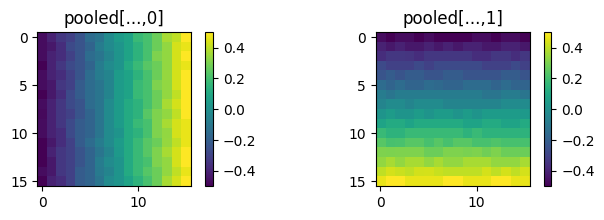

In [14]:
class AttentionPool2D(tf.keras.layers.Layer):
    """
    An alternative to MaxPool2D that tries to improve on gradient flow
    by using a soft-argmax operation.

    2D downsampling layer that computes a soft-argmax from one input to attend to the second input.
    Typically used for softmax-weighted pooling of positional inputs, based
    on the strength of the feature vectors.

    Both inputs must have the same shape (B, H, W, C). Operates channel-wise.
    Channels from each input are paired up, in sequence.

    Output shape: (B, pooled_H, pooled_W, C).
    """

    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.padding = padding.upper()

    def call(self, keys, values):
        batch_size, height, width, channels = tf.unstack(tf.shape(keys))
        tf.assert_equal(tf.shape(keys), tf.shape(values), "Input tensors must have identical shape", summarize=4)
        ksize = self.pool_size

        # Extract pool patches, eg: (assuming 2x2) (B, H//2, W//2, 2, 2, C)
        key_patches = tf.image.extract_patches(
            images=keys,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        value_patches = tf.image.extract_patches(
            images=values,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        patch_shape = tf.shape(key_patches)
        out_h, out_w = patch_shape[1], patch_shape[2]

        # Reshape to (B, out_h, out_w, 4, C)
        key_patches   = tf.reshape(key_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])
        value_patches = tf.reshape(value_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute softmax-weighted mean of values, shape: (B, out_h, out_w, C)
        attention_scores = tf.nn.softmax(key_patches, axis=-2)
        output = tf.reduce_sum(attention_scores * value_patches, axis=-2)
        return output

# check with symbolic tensors
input = tf.keras.Input(shape=(32, 32, 3))
features = StrideGrid2D()(input)
cg = CoordGrid2D()(input)
mp = AttentionPool2D()(features, cg)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# check with concrete values
input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
mp = AttentionPool2D()(features, cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("pooled[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("pooled[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

symbolic output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>, shape: (None, 32, 32, 2)
actual output (features): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)


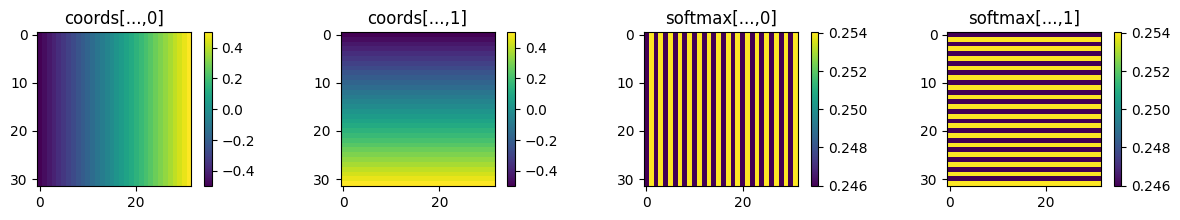

actual output (cg): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 32, 32, 2)
actual output (mp): <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 16, 16, 2)


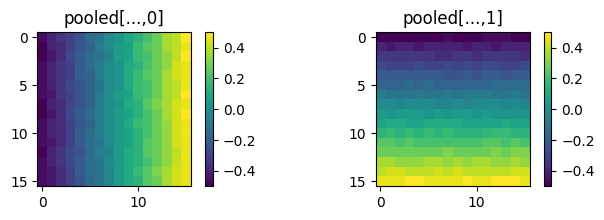

In [99]:
# The following two layers breaks out the steps of AttentionPool2D for easier interpretability.
# However, they are limited in their flexibility. They require that stride patches are exactly adjacent and non-overlapping.

class StridedSoftmax2D(tf.keras.layers.Layer):
    """
    Applies softmax to values within stride-patches.
    Treats channels independently.
    """

    def __init__(self, pool_size=(2, 2), strides=None, **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.padding = 'valid'.upper()  # can only do if using 'valid' padding

        if self.pool_size != self.strides:
            raise ValueError("pool_size and strides must be the same")

    def call(self, input):
        batch_size, height, width, channels = tf.unstack(tf.shape(input))
        ksize = self.pool_size

        # Extract pool patches, eg: (assuming 2x2) (B, H//2, W//2, 2, 2, C)
        # Then reshape to (B, out_h, out_w, 4, C)
        patches = tf.image.extract_patches(
            images=input,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        patch_shape = tf.shape(patches)
        out_h, out_w = patch_shape[1], patch_shape[2]
        patches = tf.reshape(patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute softmax for each patch
        patches = tf.nn.softmax(patches, axis=-2)

        # Convert back to original shape
        # - only possible when strides=pool_size and padding=valid
        output = tf.reshape(patches, [batch_size, out_h, out_w, ksize[0], ksize[1], channels])
        output = tf.transpose(output, [0, 1, 3, 2, 4, 5])  # eg: (B, H//2, 2, W//2, 2, C)
        output = tf.reshape(output, [batch_size, height, width, channels])

        return output

class DotPool2D(tf.keras.layers.Layer):
    """
    2D downsampling layer that combines the values between two inputs via a flattened dot-product
    applied patch-wise and channel-wise. Wordedly differently, it applies a weighted sum,
    where the first input provides the weights and the second input provides the values.
    However, you could equally phrase them the other way around.

    Both inputs must have the same shape (B, H, W, C). Operates channel-wise.
    Channels from each input are paired up, in sequence.

    Output shape: (B, pooled_H, pooled_W, C).
    """

    def __init__(self, pool_size=(2, 2), strides=None, padding='valid', **kwargs):
        super().__init__(**kwargs)

        self.pool_size = (pool_size, pool_size) if np.isscalar(pool_size) else pool_size
        if strides is None:
          self.strides = self.pool_size
        else:
          self.strides = (strides, strides) if np.isscalar(strides) else strides
        self.padding = padding.upper()

    def call(self, keys, values):
        batch_size, height, width, channels = tf.unstack(tf.shape(keys))
        tf.assert_equal(tf.shape(keys), tf.shape(values), "Input tensors must have identical shape", summarize=4)
        ksize = self.pool_size

        # Extract pool patches, eg: (assuming 2x2) (B, H//2, W//2, 2, 2, C)
        key_patches = tf.image.extract_patches(
            images=keys,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        value_patches = tf.image.extract_patches(
            images=values,
            sizes=[1, ksize[0], ksize[1], 1],
            strides=[1, self.strides[0], self.strides[1], 1],
            rates=[1, 1, 1, 1],
            padding=self.padding
        )
        patch_shape = tf.shape(key_patches)
        out_h, out_w = patch_shape[1], patch_shape[2]

        # Reshape to (B, out_h, out_w, 4, C)
        key_patches   = tf.reshape(key_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])
        value_patches = tf.reshape(value_patches, [batch_size, out_h, out_w, ksize[0]*ksize[1], channels])

        # Compute dotted sum of values, shape: (B, out_h, out_w, C)
        output = tf.reduce_sum(key_patches * value_patches, axis=-2)
        return output

# check with symbolic tensors
input = tf.keras.Input(shape=(32, 32, 3))
features = StrideGrid2D()(input)
cg = CoordGrid2D()(input)
features = StridedSoftmax2D()(features)
mp = DotPool2D()(features, cg)
print(f"symbolic output: {type(cg)}, shape: {cg.shape}")

# check with concrete values -> CoordGrid to StridedSoftmax2D
input = tf.zeros((1, 32, 32, 3))
#coords = tf.random.normal(shape=(1, 8, 8, 2)) * 50
coords = CoordGrid2D()(input)
features = StridedSoftmax2D()(coords)
print(f"actual output (features): {type(features)}, shape: {features.shape}")

plt.figure(figsize=(15,2))
plt.subplot(1,4,1)
plt.title("coords[...,0]")
plt.imshow(coords[0,:,:,0])
plt.colorbar()

plt.subplot(1,4,2)
plt.title("coords[...,1]")
plt.imshow(coords[0,:,:,1])
plt.colorbar()

plt.subplot(1,4,3)
plt.title("softmax[...,0]")
plt.imshow(features[0,:,:,0])
plt.colorbar()

plt.subplot(1,4,4)
plt.title("softmax[...,1]")
plt.imshow(features[0,:,:,1])
plt.colorbar()
plt.show()

# check with concrete values -> CoordGrid + random semantic features to StridedSoftmax + DotPool
input = tf.zeros((1, 32, 32, 3))
cg = CoordGrid2D()(input)
features = tf.random.normal(shape=(1, 32, 32, 2)) * 50
features = StridedSoftmax2D()(features)
mp = DotPool2D()(features, cg)
print(f"actual output (cg): {type(cg)}, shape: {cg.shape}")
print(f"actual output (mp): {type(mp)}, shape: {mp.shape}")

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title("pooled[...,0]")
plt.imshow(mp[0,:,:,0])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("pooled[...,1]")
plt.imshow(mp[0,:,:,1])
plt.colorbar()
plt.show()

## Test out Layers
One way to verify that the custom-layers are working correctly is to use gradient descent to optimise an input image that results in a particular desired output image after being passed into the custom layer.

This confirms how efficiently backprop gradients can flow through the layer.

For example, a global max-pool supplies backprop gradients only to the single 2D position where the max location is found, for each sample. Thus a global max-pool means that only 32 points are updated for each update step (assuming batch size 32), which is not very efficient.

In [81]:
def optimise_input(model, output, epochs=100, learning_rate=0.1):
  input_shape = model.inputs[0].shape
  input_shape = (1,) + input_shape[1:]

  optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

  input = tf.Variable(tf.random.normal(input_shape), dtype=output.dtype)
  accum_grads = tf.Variable(tf.zeros_like(input))
  print(f"initial input: shape={input.shape}, range={np.min(input)} .. {np.max(input)}")

  display_step = epochs // 10
  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      tape.watch(input)
      output = model(input)
      loss = tf.reduce_mean(tf.square(output - true_output))
    gradients = tape.gradient(loss, input)
    optimizer.apply_gradients(zip([gradients], [input]))
    accum_grads.assign_add(tf.abs(gradients))
    if epoch % display_step == 0 or epoch == epochs-1:
      print(f"Epoch {epoch+1}: loss={loss}, gradients={np.min(gradients)} .. {np.max(gradients)}, input={np.min(input)} .. {np.max(input)}")

  return input.value(), accum_grads.value()

def plot_input_optimisation_old(model, true_output, pred_input, accum_grads):
  pred_output = model(pred_input)

  plt.figure(figsize=(15,3), layout='constrained')

  plt.subplot(2,5,1)
  plt.title("true output")
  vmin, vmax = np.min(true_output), np.max(true_output)
  plt.imshow(true_output[0,...,0], vmin=vmin, vmax=vmax)
  plt.colorbar()
  plt.subplot(2,5,6)
  plt.imshow(true_output[0,...,1], vmin=vmin, vmax=vmax)
  plt.colorbar()

  plt.subplot(2,5,2)
  plt.title("pred input")
  plt.imshow(pred_input[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,7)
  plt.imshow(pred_input[0,...,1])
  plt.colorbar()

  plt.subplot(2,5,3)
  plt.title("accum input grads")
  plt.imshow(accum_grads[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,8)
  plt.imshow(accum_grads[0,...,1])
  plt.colorbar()

  plt.subplot(2,5,4)
  plt.title("pred output")
  plt.imshow(pred_output[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,9)
  plt.imshow(pred_output[0,...,1])
  plt.colorbar()

  plt.subplot(2,5,5)
  plt.title("output error")
  plt.imshow(pred_output[0,...,0] - true_output[0,...,0])
  plt.colorbar()
  plt.subplot(2,5,10)
  plt.imshow(pred_output[0,...,1] - true_output[0,...,1])
  plt.colorbar()

  plt.show()

def plot_input_optimisation(model, true_output, pred_input, accum_grads):
  def _plot_column(cols, col, title, data):
    plt.subplot(2,cols,col)
    plt.title(title)
    vmin, vmax = np.min(data), np.max(data)
    plt.imshow(data[0,...,0], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.subplot(2,cols,cols+col)
    plt.imshow(data[0,...,1], vmin=vmin, vmax=vmax)
    plt.colorbar()

  pred_output = model(pred_input)

  plt.figure(figsize=(15,3), layout='constrained')
  _plot_column(5, 1, "true output", true_output)
  _plot_column(5, 2, "pred input", pred_input)
  _plot_column(5, 3, "accum input grads", accum_grads)
  _plot_column(5, 4, "pred output", pred_output)
  _plot_column(5, 5, "output error", pred_output - true_output)
  plt.show()

First a baseline, using a few common layers.

true output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 1, 1, 2)
initial input: shape=(1, 32, 32, 2), range=-3.202916383743286 .. 2.9967832565307617
Epoch 1: loss=7.996826171875, gradients=0.0 .. 3.426783323287964, input=-3.202916383743286 .. 2.8905842304229736
Epoch 51: loss=2.396263837814331, gradients=0.0 .. 2.0215811729431152, input=-3.202916383743286 .. 1.6349389553070068
Epoch 101: loss=1.548887014389038, gradients=0.0 .. 1.6882851123809814, input=-3.202916383743286 .. 1.2963809967041016
Epoch 151: loss=1.218701958656311, gradients=0.0 .. 1.5378918647766113, input=-4.123209476470947 .. 1.1054404973983765
Epoch 201: loss=0.9105315804481506, gradients=-0.002382218837738037 .. 1.3494656085968018, input=-5.267295837402344 .. 0.9114993214607239
Epoch 251: loss=0.944648802280426, gradients=0.0 .. 1.1906120777130127, input=-6.085075855255127 .. 0.7996620535850525
Epoch 301: loss=0.5065304040908813, gradients=-0.11799830198287964 .. 0.999568521976471, input=-6.9045

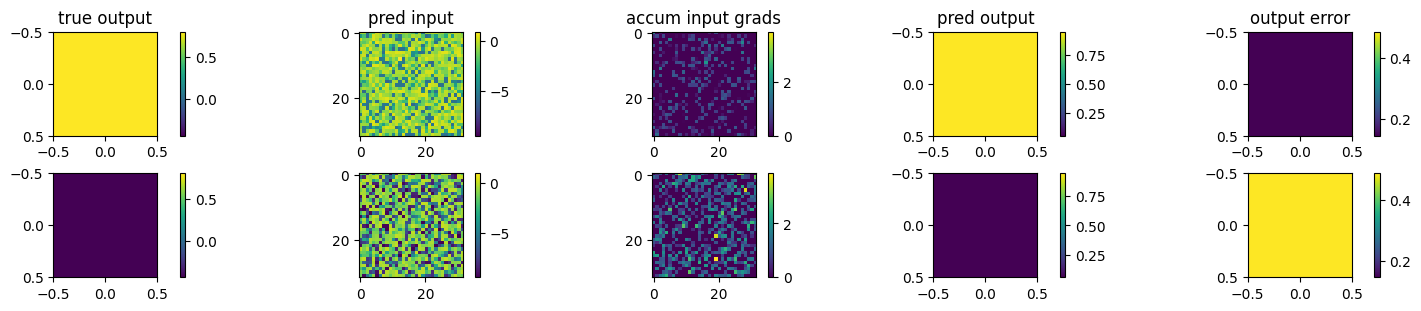

In [86]:
# Optimising input via GlobalMaxPool2D to achieve a single vector output
input = tf.keras.Input(shape=(32, 32, 2))
true_output = tf.constant([[[[0.8, -0.43]]]])
print(f"true output: {type(true_output)}, shape: {true_output.shape}")
features = layers.GlobalMaxPool2D()(input)
features = layers.Reshape(target_shape=(1,1,2))(features)  # for display as an image

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=500, learning_rate=0.5)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.7900454998016357 .. 3.184896945953369
Epoch 1: loss=1.7369039058685303, gradients=-0.0031218286603689194 .. 0.013612878508865833, input=-3.7900454998016357 .. 3.084920883178711
Epoch 11: loss=0.44670605659484863, gradients=-0.0007960434886626899 .. 0.009752982296049595, input=-3.7900454998016357 .. 2.1006734371185303
Epoch 21: loss=0.09656426310539246, gradients=-0.0010795412817969918 .. 0.006179021671414375, input=-3.7900454998016357 .. 1.1974905729293823
Epoch 31: loss=0.021352987736463547, gradients=-0.001087428187020123 .. 0.0038174085784703493, input=-3.7900454998016357 .. 0.5996922254562378
Epoch 41: loss=0.005700855981558561, gradients=-0.0009554588468745351 .. 0.0019761717412620783, input=-3.7900454998016357 .. 0.5720780491828918
Epoch 51: loss=0.00176911277230829, gradients=-0.0006672844756394625 .. 0.0007880623452365398, input=-3.7900454998016357 .. 0.5607130527496338
Epoch 61: loss=0.0005972916842438281, gradients=-0.000512281665

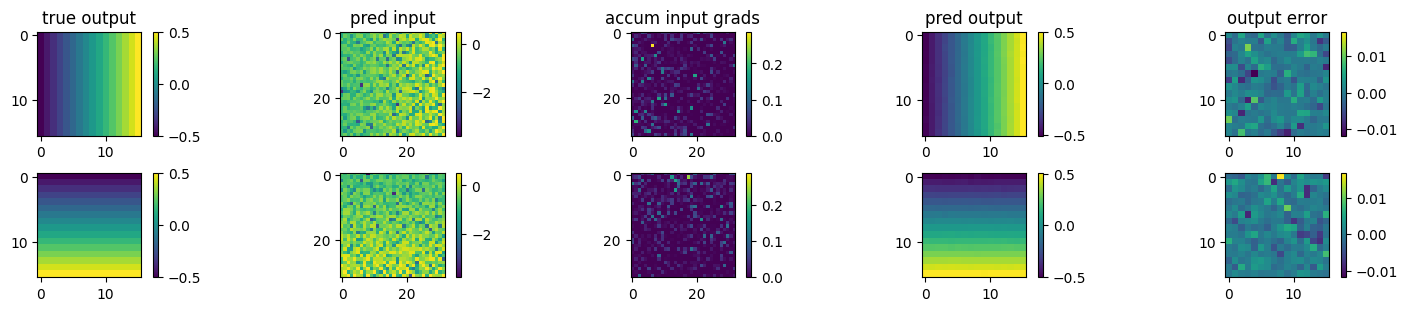

In [84]:
# Optimising input via MaxPool2D to achieve a CoordGrid output
input = tf.keras.Input(shape=(32, 32, 2))
features = layers.MaxPool2D()(input)
true_output = CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.1663758754730225 .. 3.2906296253204346
Epoch 1: loss=1.0516719818115234, gradients=-0.004468503408133984 .. 0.0049532679840922356, input=-3.066465377807617 .. 3.1906940937042236
Epoch 51: loss=0.04641009122133255, gradients=-0.0002183010074077174 .. 0.00023540621623396873, input=-2.1199533939361572 .. 2.9373655319213867
Epoch 101: loss=0.03663714975118637, gradients=-0.00011228390940232202 .. 6.030443182680756e-05, input=-2.4937245845794678 .. 3.4507501125335693
Epoch 151: loss=0.033126384019851685, gradients=-6.634738383581862e-05 .. 4.216729212203063e-05, input=-2.6544346809387207 .. 3.5065829753875732
Epoch 201: loss=0.03067765012383461, gradients=-3.913689943146892e-05 .. 3.1809777283342555e-05, input=-2.789506435394287 .. 3.465226888656616
Epoch 251: loss=0.0288078635931015, gradients=-3.2101976103149354e-05 .. 2.4919056158978492e-05, input=-2.9155330657958984 .. 3.431943893432617
Epoch 301: loss=0.027346057817339897, gradients=-2.5840

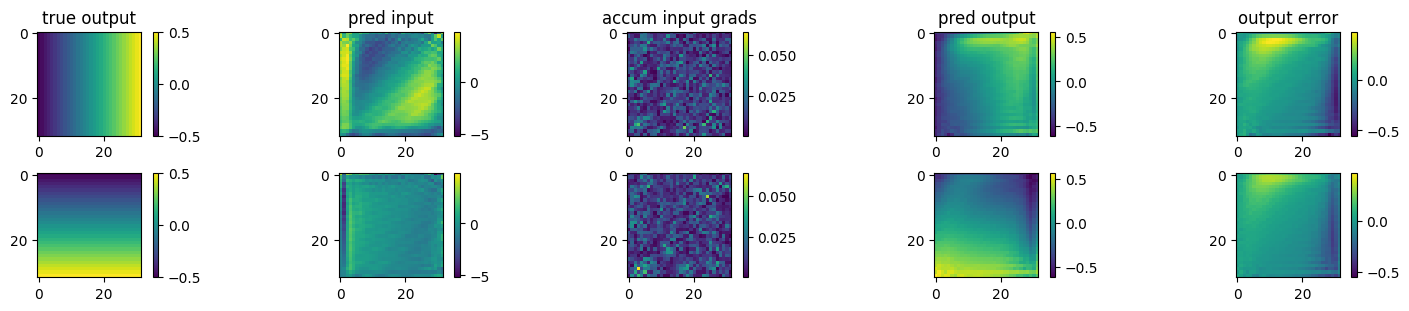

In [87]:
# Optimising input via Conv2D to achieve a CoordGrid output
input = tf.keras.Input(shape=(32, 32, 2))
features = layers.Conv2D(filters=2, kernel_size=3, padding='same')(input)
true_output = CoordGrid2D()(tf.zeros((1, 32, 32, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=500)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

Now we'll test our custom layers.

true output: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 2, 2)
initial input: shape=(1, 32, 32, 2), range=-3.317992687225342 .. 3.7369978427886963
Epoch 1: loss=0.24554602801799774, gradients=-0.2875767648220062 .. 0.0, input=-3.317992687225342 .. 3.836949110031128
Epoch 4: loss=0.16125145554542542, gradients=-0.009308170527219772 .. 0.0004551708698272705, input=-3.317992687225342 .. 4.103919982910156
Epoch 7: loss=0.1551150679588318, gradients=-0.0052994657307863235 .. 0.0014606937766075134, input=-3.317992687225342 .. 4.324464321136475
Epoch 10: loss=0.1523614227771759, gradients=-0.004033394157886505 .. 0.001553775742650032, input=-3.317992687225342 .. 4.507480144500732
Epoch 13: loss=0.15067481994628906, gradients=-0.003416169434785843 .. 0.0015432611107826233, input=-3.317992687225342 .. 4.660160541534424
Epoch 16: loss=0.14946970343589783, gradients=-0.0030539054423570633 .. 0.0015186332166194916, input=-3.317992687225342 .. 4.787838459014893
Epoch 19: loss=

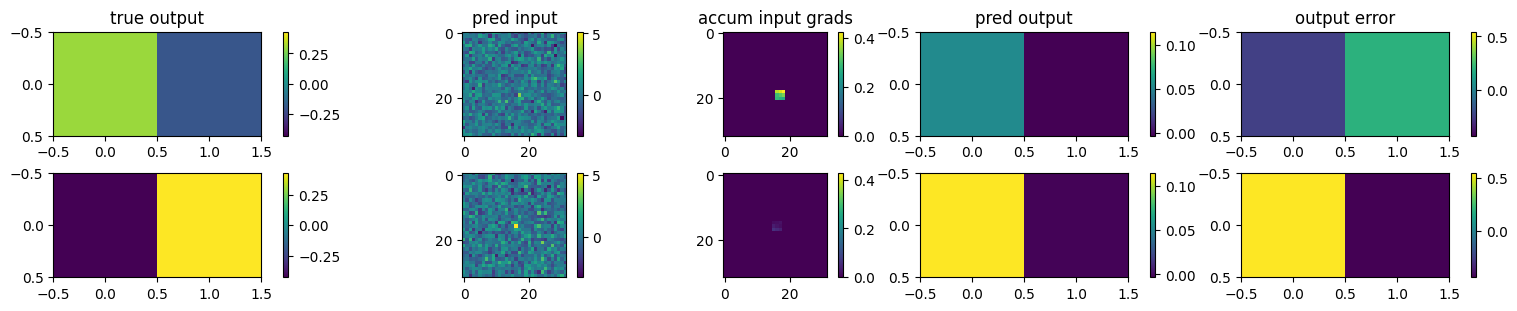

In [120]:
# Optimising input via HeatmapPeakCoord to achieve a single vector output
# - Here you can see how the HeatmapPeakCoord must be used with care.
#   When asking it to emit a particular output coordinate it may not be possible to converge.
#   Training starts from wherever the first predicted peak is, and only applies gradients
#   to the 3x3 grid near that peak. The coordinates are based on the coordinates of those pixels,
#   and thus the best it can do is maximise the pixel that's closest to the desired coordinate.

input = tf.keras.Input(shape=(32, 32, 2))
true_output = tf.constant([[[0.3, -0.43], [-0.2, 0.43]]])
print(f"true output: {type(true_output)}, shape: {true_output.shape}")
features = HeatmapPeakCoord()(input)
features = layers.Reshape(target_shape=(1,2,2))(features)  # for display as an image

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=30, learning_rate=0.1)

true_output = tf.reshape(true_output, (1,1,2,2))  # for display as an image
plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.7978856563568115 .. 3.4706032276153564
Epoch 1: loss=2.354628562927246, gradients=-0.014444866217672825 .. 0.013947668485343456, input=-3.6979081630706787 .. 3.370626449584961
Epoch 11: loss=0.8393492102622986, gradients=-0.010581698268651962 .. 0.01008639857172966, input=-2.7125370502471924 .. 2.3859071731567383
Epoch 21: loss=0.26562392711639404, gradients=-0.007074179593473673 .. 0.0071025025099515915, input=-1.8397517204284668 .. 1.6534788608551025
Epoch 31: loss=0.06859993934631348, gradients=-0.005518456920981407 .. 0.004811456426978111, input=-1.185981035232544 .. 1.1296252012252808
Epoch 41: loss=0.020397895947098732, gradients=-0.003657206427305937 .. 0.0029245337937027216, input=-0.7586612701416016 .. 0.799220621585846
Epoch 51: loss=0.01050847303122282, gradients=-0.00238272687420249 .. 0.0020992110949009657, input=-0.7886776328086853 .. 0.6674515008926392
Epoch 61: loss=0.005033301655203104, gradients=-0.0013597984798252583 .. 0

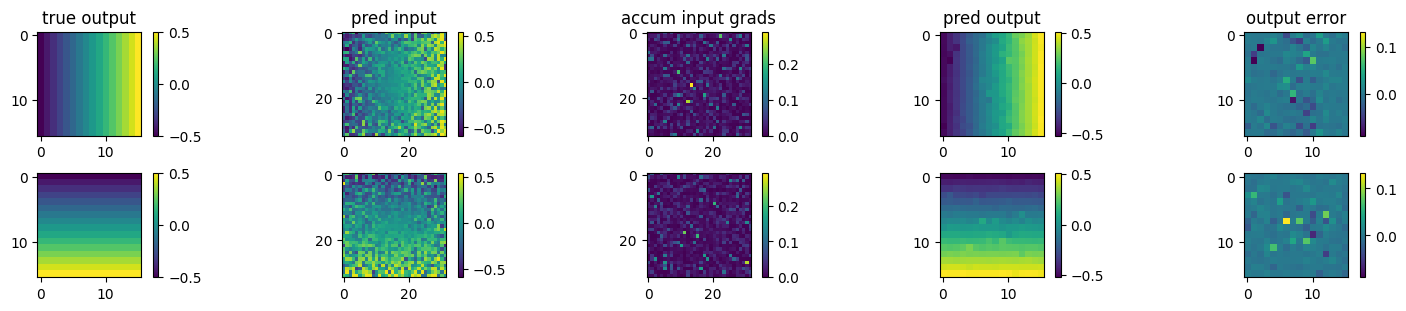

In [122]:
# Optimising input via PositionwiseMaxPool2D to achieve a CoordGrid output
# - This shows how the gradients only take strong effect against the max positions in each 2x2 patch,
#   where the remaining 3/4 pixels stay near their initialised state.
#   (the max positions might change initially, so that other pixels get some gradients, but it'll be short lived)
# - With care, you can also see how it ties the two channels together.

input = tf.keras.Input(shape=(32, 32, 2))
features = PositionwiseMaxPool2D()(input)
true_output = CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.278883218765259 .. 3.4246652126312256
Epoch 1: loss=0.1854330599308014, gradients=-8.85524568730034e-05 .. 0.0001259741693502292, input=-3.023735523223877 .. 2.9394619464874268
Epoch 51: loss=0.15109246969223022, gradients=-1.4584465134248603e-05 .. 3.571783963707276e-05, input=-1.750422716140747 .. 2.5477957725524902
Epoch 101: loss=0.15095019340515137, gradients=-1.0883716186071979e-06 .. 2.3417987904394977e-06, input=-1.760168433189392 .. 2.556328773498535
Epoch 151: loss=0.15094953775405884, gradients=-4.695400832588348e-07 .. 1.9278580509762833e-07, input=-1.760202169418335 .. 2.555053234100342
Epoch 201: loss=0.15094953775405884, gradients=-1.5882039861025987e-07 .. 1.9986751453870966e-07, input=-1.760267972946167 .. 2.5546255111694336
Epoch 251: loss=0.1509495973587036, gradients=-1.698168716757209e-06 .. 2.0920633687637746e-06, input=-1.7602694034576416 .. 2.554581642150879
Epoch 301: loss=0.15094955265522003, gradients=-1.049282218

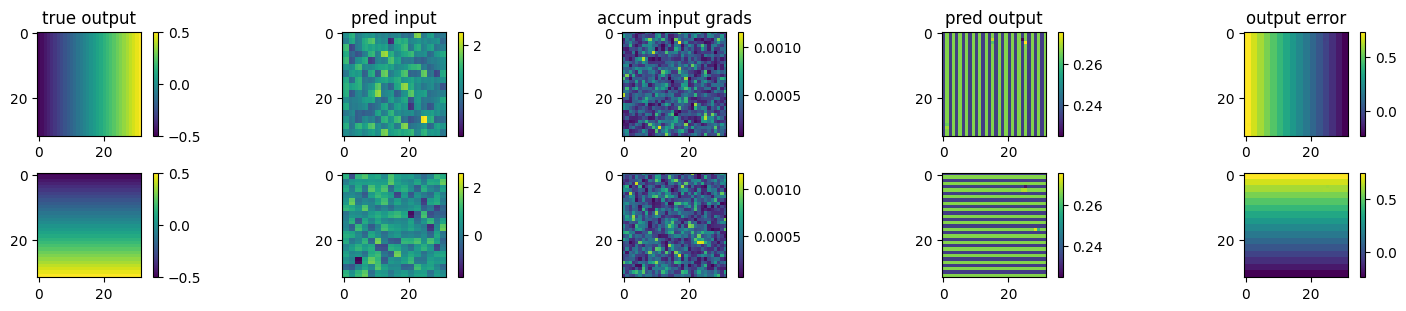

In [100]:
# Optimising input via StridedSoftmax2D to achieve a CoordGrid output
# - this produces an initially surprising result: horizontal and vertical bands of approximately equal magnitude
# - but this is all that it can do, because softmax also performs a normalization, forcing the sum of the patch to 1.0
# - so it's impossible for it to produce the gradient, and the best it can do is make the correct side of each 2x2 patch higher than the other.
input = tf.keras.Input(shape=(32, 32, 2))
features = StridedSoftmax2D()(input)
true_output = CoordGrid2D()(tf.zeros((1, 32, 32, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=500, learning_rate=0.5)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.520918607711792 .. 3.4612979888916016
Epoch 1: loss=0.00013955139729660004, gradients=-4.9555615078134e-07 .. 5.413595545178396e-07, input=-3.520862102508545 .. 3.461284875869751
Epoch 11: loss=0.00010967699927277863, gradients=-5.64827018934011e-07 .. 5.601726229542692e-07, input=-3.5195934772491455 .. 3.460963249206543
Epoch 21: loss=7.113035098882392e-05, gradients=-5.582393214353942e-07 .. 5.12727353907394e-07, input=-3.5180444717407227 .. 3.46044659614563
Epoch 31: loss=3.990736149717122e-05, gradients=-5.191362220102747e-07 .. 4.7652795842623163e-07, input=-3.5168280601501465 .. 3.4598073959350586
Epoch 41: loss=2.0521090846159495e-05, gradients=-4.779591336045996e-07 .. 3.822911764927994e-07, input=-3.516101360321045 .. 3.45908260345459
Epoch 51: loss=1.0256520909024402e-05, gradients=-4.929880219606275e-07 .. 3.2690644502508803e-07, input=-3.515778064727783 .. 3.458299160003662
Epoch 61: loss=5.341205451259157e-06, gradients=-2.7949

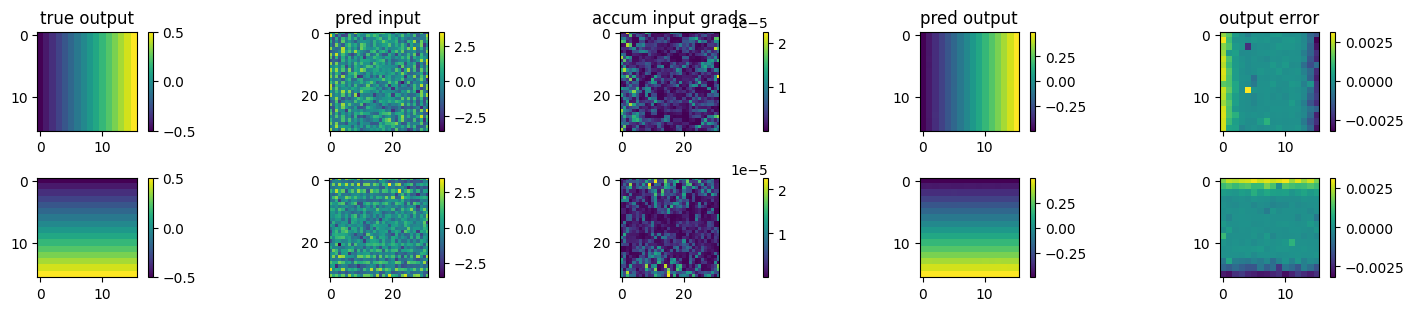

In [102]:
# Optimising input features via StridedSoftmax2D and DotPool2D to achieve a CoordGrid output
input = tf.keras.Input(shape=(32, 32, 2))
features = StridedSoftmax2D()(input)
features = DotPool2D()(features, CoordGrid2D()(input))
true_output = CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=100, learning_rate=0.1)

plot_input_optimisation(model, true_output, pred_input, accum_grads)

initial input: shape=(1, 32, 32, 2), range=-3.407675266265869 .. 2.8576443195343018
Epoch 1: loss=0.00013544491957873106, gradients=-5.798949018753774e-07 .. 5.298020369082224e-07, input=-3.407435178756714 .. 2.8558335304260254
Epoch 11: loss=0.00010506082617212087, gradients=-5.814544579152425e-07 .. 5.636208015857846e-07, input=-3.402031421661377 .. 2.8118112087249756
Epoch 21: loss=6.612188735743985e-05, gradients=-4.75246707765109e-07 .. 5.421510422820575e-07, input=-3.3953356742858887 .. 2.9536311626434326
Epoch 31: loss=3.509510861476883e-05, gradients=-5.189918965697871e-07 .. 5.170166446077928e-07, input=-3.38997220993042 .. 3.191725492477417
Epoch 41: loss=1.6687950846971944e-05, gradients=-4.1412857854083995e-07 .. 3.5000383036276617e-07, input=-3.386732339859009 .. 3.3676764965057373
Epoch 51: loss=7.839508725737687e-06, gradients=-4.7638559408369474e-07 .. 3.113406705779198e-07, input=-3.3853414058685303 .. 3.4849295616149902
Epoch 61: loss=3.979068878834369e-06, gradients=

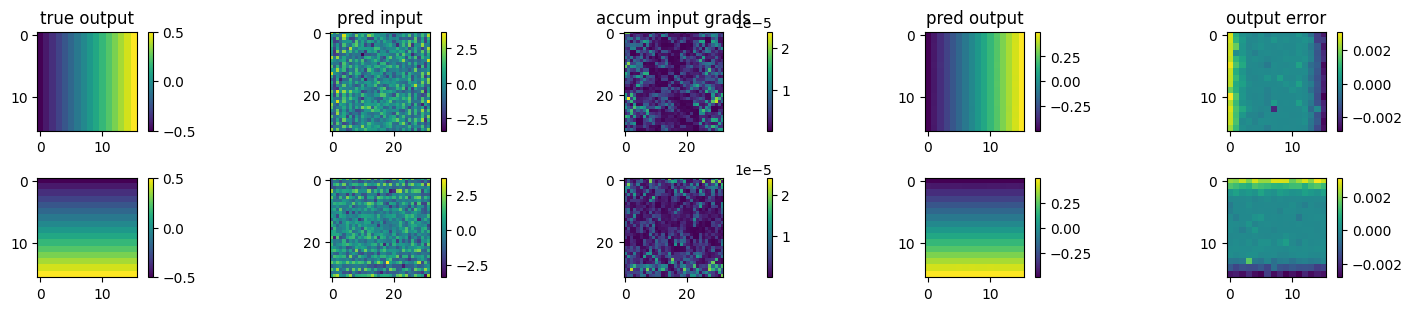

In [104]:
# Optimising input features via AttentionPool2D to achieve a CoordGrid output
# - Notice that the appearance of the optimised input here looks the same as when using StridedSoftmax2D and DotPool2D, confirming that they're both doing the same thing.
input = tf.keras.Input(shape=(32, 32, 2))
features = AttentionPool2D()(input, CoordGrid2D()(input))
true_output = CoordGrid2D()(tf.zeros((1, 16, 16, 3)))

model = tf.keras.Model(inputs=input, outputs=features)
pred_input, accum_grads = optimise_input(model, true_output, epochs=100, learning_rate=0.1)

plot_input_optimisation(model, true_output, pred_input, accum_grads)